In [93]:
import numpy as np 
import pandas as pd 

# For Preprocesssing Text Data
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# Feature Extraction
from sklearn.feature_extraction.text import TfidfVectorizer

# Import the train test split
from sklearn.model_selection import train_test_split

# Check Performance
from sklearn.metrics import classification_report

In [225]:
data = pd.read_csv("C:/Users/johnr/Downloads/IPBA files/Disaster Tweets/train.csv")
data.head(2)

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1


In [95]:
data['target'].value_counts()

0    4342
1    3271
Name: target, dtype: int64

# Sentiment Analysis

In [166]:
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
from scipy.special import softmax

In [167]:
MODEL = f"cardiffnlp/twitter-roberta-base-sentiment"
tokenizer = AutoTokenizer.from_pretrained(MODEL)
model = AutoModelForSequenceClassification.from_pretrained(MODEL)

In [168]:
def robertaBaseSentiment(example):
    encoded = tokenizer(example, return_tensors = 'pt')
    output = model(**encoded)
    score = output[0][0].detach().numpy()
    score = softmax(score)
    result = {
        'Negative': score[0],
        'Neutral': score[1],
        'Positive': score[2]
    }
    return result

In [169]:
SentimentResults = {}
from tqdm import tqdm 
for i, row in tqdm(data.iterrows(), total=len(data)):
    text = row['text']
    myid = row['id']
    SentimentResults[myid] = robertaBaseSentiment(text)

100%|██████████████████████████████████████████████████████████████████████████████| 7613/7613 [11:39<00:00, 10.89it/s]


In [200]:
SentimentsDataFrame = pd.DataFrame(SentimentResults).T
SentimentsDataFrame = SentimentsDataFrame.reset_index().rename(columns = {'index' : 'id'})
SentimentsDataFrame

,id,Negative,Neutral,Positive
0,1,0.014449,0.408867,0.576684
1,4,0.296715,0.678166,0.025119
2,5,0.124597,0.848869,0.026534
3,6,0.186091,0.767272,0.046637
4,7,0.579952,0.394576,0.025472
...,...,...,...,...
7608,10869,0.296147,0.661897,0.041956
7609,10870,0.697816,0.285184,0.017000
7610,10871,0.083853,0.880907,0.035240
7611,10872,0.642819,0.329604,0.027577


In [226]:
data = data.merge(SentimentsDataFrame, how = 'left')
data.head(2)

,id,keyword,location,text,target,Negative,Neutral,Positive
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,0.014449,0.408867,0.576684
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,0.296715,0.678166,0.025119


# Conversion to lower case

In [102]:
data['text'] = data['text'].apply(lambda x: x.lower())
data.head()

,id,keyword,location,text,target,Negative,Neutral,Positive
0,1,NaN,NaN,our deeds are the reason of this #earthquake m...,1,0.254576,0.511313,0.234111
1,4,NaN,NaN,forest fire near la ronge sask. canada,1,0.254576,0.511313,0.234111
2,5,NaN,NaN,all residents asked to 'shelter in place' are ...,1,0.254576,0.511313,0.234111
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,0.254576,0.511313,0.234111
4,7,NaN,NaN,just got sent this photo from ruby #alaska as ...,1,0.254576,0.511313,0.234111


# Removing Punctuations

In [103]:
import string 
def removing_punctuations(a):
    for punctuation in string.punctuation:
        a = [c for c in a if c not in string.punctuation]
        return ''.join(a)

In [104]:
data['text'].apply(removing_punctuations)

0       our deeds are the reason of this earthquake ma...
1                   forest fire near la ronge sask canada
2       all residents asked to shelter in place are be...
3       13000 people receive wildfires evacuation orde...
4       just got sent this photo from ruby alaska as s...
                              ...                        
7608    two giant cranes holding a bridge collapse int...
7609    ariaahrary thetawniest the out of control wild...
7610    m194 0104 utc5km s of volcano hawaii httptcozd...
7611    police investigating after an ebike collided w...
7612    the latest more homes razed by northern califo...
Name: text, Length: 7613, dtype: object

# Removing Stopwords

In [105]:
nltk.download('stopwords')
stopWordsEng = stopwords.words('english')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\johnr\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [106]:
data['text'] = data['text'].apply(lambda x: [word for word in x.split() if word not in stopWordsEng])

In [107]:
data['text']

0       [deeds, reason, #earthquake, may, allah, forgi...
1          [forest, fire, near, la, ronge, sask., canada]
2       [residents, asked, 'shelter, place', notified,...
3       [13,000, people, receive, #wildfires, evacuati...
4       [got, sent, photo, ruby, #alaska, smoke, #wild...
                              ...                        
7608    [two, giant, cranes, holding, bridge, collapse...
7609    [@aria_ahrary, @thetawniest, control, wild, fi...
7610    [m1.94, [01:04, utc]?5km, volcano, hawaii., ht...
7611    [police, investigating, e-bike, collided, car,...
7612    [latest:, homes, razed, northern, california, ...
Name: text, Length: 7613, dtype: object

In [108]:
data['text'] = data['text'].apply(lambda x: ' '.join(x))
data['text']

0           deeds reason #earthquake may allah forgive us
1                  forest fire near la ronge sask. canada
2       residents asked 'shelter place' notified offic...
3       13,000 people receive #wildfires evacuation or...
4       got sent photo ruby #alaska smoke #wildfires p...
                              ...                        
7608    two giant cranes holding bridge collapse nearb...
7609    @aria_ahrary @thetawniest control wild fires c...
7610    m1.94 [01:04 utc]?5km volcano hawaii. http://t...
7611    police investigating e-bike collided car littl...
7612    latest: homes razed northern california wildfi...
Name: text, Length: 7613, dtype: object

# Train Test Split

In [227]:
target = data['target']
variables = data['text']

In [228]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(variables.values, target.values, test_size=0.2, random_state=0, stratify=target.values)

In [229]:
X_train

array(["There's a fire in the Catalinas. Looks kinda cool. This picture doesn't do it justice. https://t.co/N0tAwGeZJx",
       ". @VELDFest announces refunds after Day two's extreme weather evacuation: http://t.co/PP05eTlK7t http://t.co/3Ol8MhhPMa",
       '@bomairinge @EluTranscendent straight body bagging.', ...,
       "'Money can't buy happiness' is just a lie we tell poor people to keep them from rioting.",
       'recap/ 12000 Nigerian refugees repatriated from Cameroon http://t.co/po19h8YCND',
       "If Ryan doesn't release new music soon I might explode"],
      dtype=object)

# Vectorizer

In [230]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer() 
vectorized_train = vectorizer.fit_transform(X_train)
Xtest_vector = vectorizer.transform(X_test)
vectorized_train

<6090x18533 sparse matrix of type '<class 'numpy.float64'>'
	with 89109 stored elements in Compressed Sparse Row format>

# Model Building

In [15]:
from sklearn.naive_bayes import MultinomialNB
clf = MultinomialNB()
clf.fit(vectorized_train,y_train)

MultinomialNB()

In [16]:
from sklearn.ensemble import RandomForestClassifier
classifier = RandomForestClassifier()
classifier.fit(vectorized_train,y_train)

RandomForestClassifier()

# Predictions

In [17]:
RandomForestPred = classifier.predict(Xtest_vector)

In [18]:
MultinomialPreds = clf.predict(Xtest_vector)

# Classification Report

In [19]:
print(classification_report(y_test, MultinomialPreds))

              precision    recall  f1-score   support

           0       0.77      0.91      0.84       869
           1       0.85      0.65      0.73       654

    accuracy                           0.80      1523
   macro avg       0.81      0.78      0.79      1523
weighted avg       0.81      0.80      0.79      1523



In [20]:
print(classification_report(y_test, RandomForestPred))

              precision    recall  f1-score   support

           0       0.75      0.91      0.82       869
           1       0.83      0.60      0.70       654

    accuracy                           0.78      1523
   macro avg       0.79      0.75      0.76      1523
weighted avg       0.79      0.78      0.77      1523



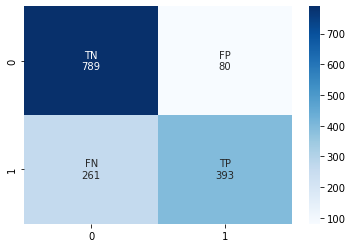

In [21]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
cnf_matrix = confusion_matrix(y_test,RandomForestPred)
group_names = ['TN','FP','FN','TP']
group_counts = ["{0:0.0f}".format(value) for value in cnf_matrix.flatten()]
labels = [f"{v1}\n{v2}" for v1, v2 in zip(group_names,group_counts)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cnf_matrix, annot=labels, fmt='', cmap='Blues');

# Submission Prediction

In [22]:
submissionData = pd.read_csv("C:/Users/johnr/Downloads/IPBA files/Disaster Tweets/test.csv")
submission_text = submissionData['text']

In [23]:
submissionData['text'].apply(lambda x : x.lower())
submissionData['text'].apply(removing_punctuations)
submissionData['text'].apply(lambda x: [word for word in x.split() if word not in stopWordsEng])
submissionData['text'].apply(lambda x:''.join(x))

0                      Just happened a terrible car crash
1       Heard about #earthquake is different cities, s...
2       there is a forest fire at spot pond, geese are...
3                Apocalypse lighting. #Spokane #wildfires
4           Typhoon Soudelor kills 28 in China and Taiwan
                              ...                        
3258    EARTHQUAKE SAFETY LOS ANGELES ÛÒ SAFETY FASTE...
3259    Storm in RI worse than last hurricane. My city...
3260    Green Line derailment in Chicago http://t.co/U...
3261    MEG issues Hazardous Weather Outlook (HWO) htt...
3262    #CityofCalgary has activated its Municipal Eme...
Name: text, Length: 3263, dtype: object

In [24]:
vectorized_submission = vectorizer.transform(submissionData['text'].values)

In [25]:
sumbissionPreds = classifier.predict(vectorized_submission)
sumbissionPreds

array([0, 1, 1, ..., 1, 1, 0], dtype=int64)

In [26]:
submission = pd.DataFrame()
submission['id'] = submissionData['id']
submission['target'] = sumbissionPreds

In [27]:
submission.to_csv("C:/Users/johnr/Downloads/IPBA files/Disaster Tweets/submission.csv")